# Introduction
#This project develops a predictive model for bank term deposit subscriptions, a critical application in financial services marketing. By analyzing customer demographic, financial, and campaign interaction data, the model identifies clients most likely to subscribe. Achieving a high F1 score of 0.945 demonstrates strong predictive capability for this imbalanced classification task. The insights generated help optimize marketing resource allocation and improve campaign conversion rates. This work showcases the practical application of machine learning to drive business value in the banking sector.

# Problem Statement 
#Bank marketing campaigns traditionally suffer from low conversion rates and inefficient resource allocation due to indiscriminate customer targeting. This project addresses this by building a precise predictive model to identify high-potential clients, enabling targeted outreach that maximizes subscription rates while minimizing contact costs.

# Import all Libraries

In [1]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_curve, roc_auc_score

In [2]:
df=pd.read_csv("C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\bank-full.csv",delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Basic Data Understanding

In [3]:
df=df.drop(['duration'],axis='columns')
print(f'Shape of the Dataset:{df.shape}\n')
print(f'Null Values in Dataset:\n{df.isnull().sum()}\n')
print(f'Duplicated Values in Dataset:{df.duplicated().sum()}\n')
print(f'Drop Duplicated Values:{df.drop_duplicates(inplace=True)}\n')
print(f'Basic Information about Dataset:{df.info()}')

Shape of the Dataset:(45211, 16)

Null Values in Dataset:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Duplicated Values in Dataset:16

Drop Duplicated Values:None

<class 'pandas.core.frame.DataFrame'>
Index: 45195 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45195 non-null  int64 
 1   job        45195 non-null  object
 2   marital    45195 non-null  object
 3   education  45195 non-null  object
 4   default    45195 non-null  object
 5   balance    45195 non-null  int64 
 6   housing    45195 non-null  object
 7   loan       45195 non-null  object
 8   contact    45195 non-null  object
 9   day        45195 non-null  int64 
 10  month      45195 non-null  object
 11  campaign  

In [4]:
df_cate=df.select_dtypes(include='object')
df_category=df_cate.columns
print(f'Total Numbers of Categorical variable is {len(df_category)}')
df_num=df.select_dtypes(include='number')
df_number=df_num.columns
print(f'Total Number of Numerical data is {len(df_number)}')

Total Numbers of Categorical variable is 10
Total Number of Numerical data is 6


In [5]:
print(f'Basic Summary of Numerical Features:\n{df.describe()}')

Basic Summary of Numerical Features:
                age        balance           day      campaign         pdays  \
count  45195.000000   45195.000000  45195.000000  45195.000000  45195.000000   
mean      40.937604    1362.754331     15.804824      2.763978     40.212413   
std       10.619108    3045.196838      8.322816      3.098304    100.143468   
min       18.000000   -8019.000000      1.000000      1.000000     -1.000000   
25%       33.000000      72.000000      8.000000      1.000000     -1.000000   
50%       39.000000     449.000000     16.000000      2.000000     -1.000000   
75%       48.000000    1428.000000     21.000000      3.000000     -1.000000   
max       95.000000  102127.000000     31.000000     63.000000    871.000000   

           previous  
count  45195.000000  
mean       0.580529  
std        2.303823  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


In [6]:
print(f"Basic Summary of Categorical Features:\n{df.describe(include='object')}")

Basic Summary of Categorical Features:
                job  marital  education default housing   loan   contact  \
count         45195    45195      45195   45195   45195  45195     45195   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           9730    27208      23199   44380   25126  37951     29271   

        month poutcome      y  
count   45195    45195  45195  
unique     12        4      2  
top       may  unknown     no  
freq    13764    36943  39906  


In [7]:
def age_group(age):
    if age < 20:
        return 'Teen'
    elif age < 35:
        return 'Young'
    elif age < 60:
        return 'Men'
    else:
        return 'Old'
df['age_group'] = df['age'].apply(age_group)

In [8]:
def create_week_group(day):
    if day <= 7:
        return 'Week 1'
    elif day <= 14:
        return 'Week 2'
    elif day <= 21:
        return 'Week 3'
    else:
        return 'Week 4'

df['week_group'] = df['day'].apply(create_week_group)
df=df.drop(['day','age'],axis='columns')

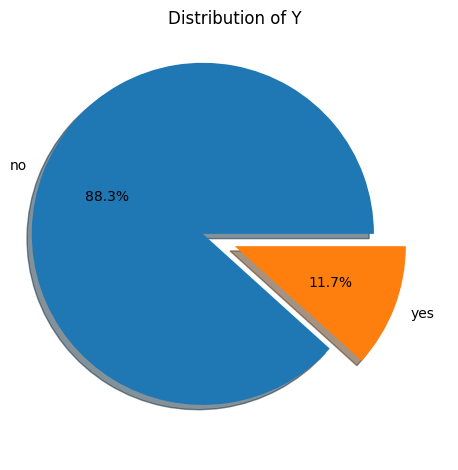

In [9]:
count=df.y.value_counts()
index=np.argmax(count)
explode=[0.2 if i == index else 0 for i in range(len(count))]
plt.pie(count,labels=count.index,explode=explode,autopct='%1.1f%%',shadow=True)
plt.title("Distribution of Y")
plt.tight_layout()
plt.savefig("C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\Task 4\\Distribution of Y.png", 
            dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')   

# Outlier Detection

In [10]:
def remove_extreme_outliers(df, columns, lower_percentile=0.01, upper_percentile=0.99):
    df_clean = df.copy()
    
    for col in columns:
        if col in df_clean.columns:
            lower_bound = df_clean[col].quantile(lower_percentile)
            upper_bound = df_clean[col].quantile(upper_percentile)
            df_clean = df_clean[
                (df_clean[col] >= lower_bound) & 
                (df_clean[col] <= upper_bound)
            ]
    removed = len(df) - len(df_clean)
    print(f"Original: {len(df):,} rows")
    print(f"Cleaned: {len(df_clean):,} rows")
    print(f"Removed: {removed:,} rows ({removed/len(df)*100:.1f}%)")
    return df_clean.reset_index(drop=True)

In [11]:
clean_data=remove_extreme_outliers(df, ['balance','pdays','campaign']
                                   , lower_percentile=0.01, upper_percentile=0.99)

Original: 45,195 rows
Cleaned: 43,475 rows
Removed: 1,720 rows (3.8%)


# Summary 

In [12]:
clean_data['y_numeric'] = clean_data['y'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)
for col in ['job', 'marital', 'education', 'default', 'housing'
            , 'loan','week_group','age_group','contact','poutcome']:
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR: {col.upper()}")
    print(f"{'='*60}")
    dist = clean_data.groupby(col)['y_numeric'].agg(['mean', 'count'])
    dist = dist.rename(columns={'mean': 'conversion_rate', 'count': 'sample_size'})
    dist['conversion_pct'] = (dist['conversion_rate'] * 100).round(2)
    dist = dist.sort_values('conversion_rate', ascending=False)
    print(f"{'Category':<25} {'Conv Rate':>12} {'Sample':>10} {'Pct':>8}")
    print(f"{'-'*25} {'-'*12} {'-'*10} {'-'*8}")
    for idx, row in dist.iterrows():
        print(f"{str(idx):<25} {row['conversion_rate']:>11.3f} {row['sample_size']:>10,} {row['conversion_pct']:>7.1f}%")
    print(f"\nSummary:")
    print(f"  • Highest conversion: {dist.index[0]} ({dist.iloc[0]['conversion_pct']:.1f}%)")
    print(f"  • Lowest conversion: {dist.index[-1]} ({dist.iloc[-1]['conversion_pct']:.1f}%)")
    print(f"  • Range: {dist.iloc[0]['conversion_pct'] - dist.iloc[-1]['conversion_pct']:.1f}% points")


ANALYSIS FOR: JOB
Category                     Conv Rate     Sample      Pct
------------------------- ------------ ---------- --------
student                         0.283      907.0    28.3%
retired                         0.226    2,182.0    22.6%
unemployed                      0.153    1,259.0    15.2%
management                      0.137    8,961.0    13.7%
admin.                          0.120    4,998.0    12.0%
self-employed                   0.116    1,517.0    11.6%
technician                      0.109    7,293.0    10.9%
unknown                         0.108      277.0    10.8%
services                        0.088    4,022.0     8.8%
housemaid                       0.088    1,210.0     8.8%
entrepreneur                    0.079    1,425.0     7.9%
blue-collar                     0.073    9,424.0     7.3%

Summary:
  • Highest conversion: student (28.3%)
  • Lowest conversion: blue-collar (7.3%)
  • Range: 21.0% points

ANALYSIS FOR: MARITAL
Category                    

# Exploratory Data Analysis

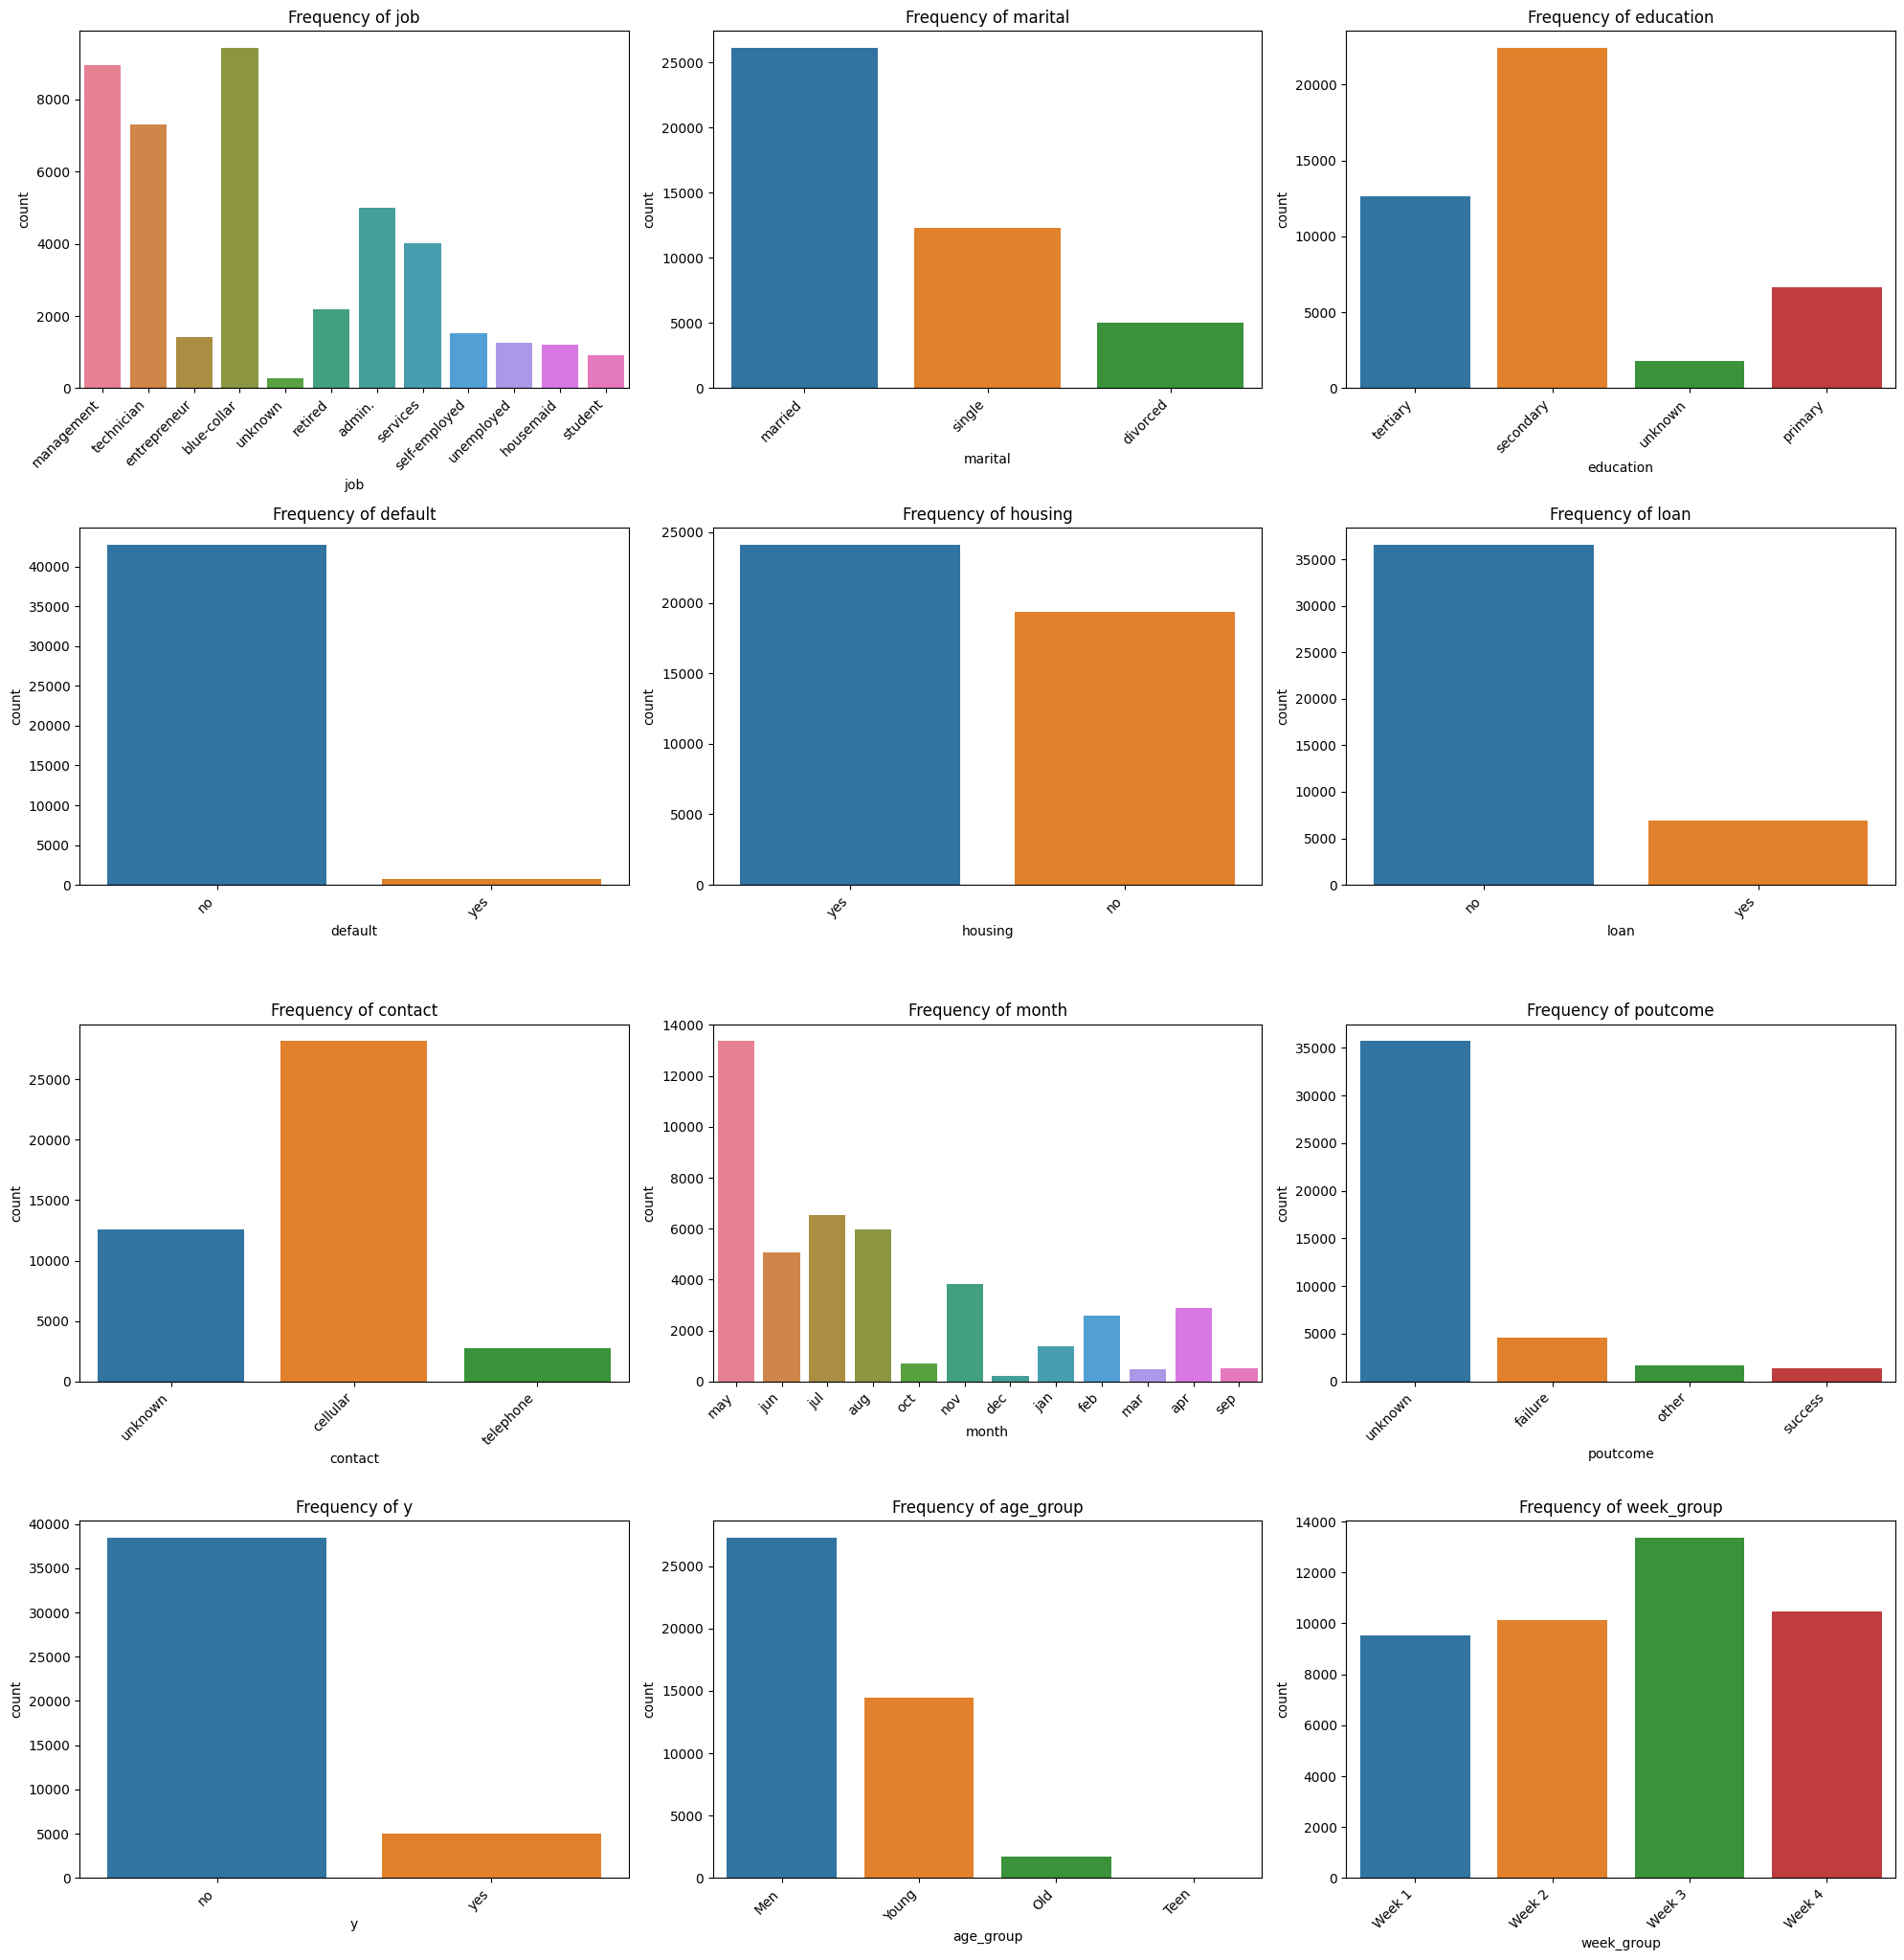

In [13]:
plt.figure(figsize=(20,25))
df_cate=clean_data.select_dtypes(include='object')
for i,col in enumerate(df_cate):
    plt.subplot(5,3,i+1)
    sns.countplot(data=clean_data,x=col,hue=col)
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.savefig("C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\Task 4\\Distribution of Categorical.png", 
            dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none') 

In [14]:
def categorical_variable(df, col, target_col, palette):
    dt = df.groupby(col)[target_col].agg('mean').reset_index()
    dt = dt.sort_values(by=target_col, ascending=False)  
    plt.figure(figsize=(10, 6))
    plot = sns.barplot(data=dt, x=col, y=target_col, hue=col, palette=palette, legend=False)
    for p in plot.patches:
        percentage = p.get_height() * 100  
        plot.annotate(f'{percentage:.1f}%', 
                     (p.get_x() + p.get_width()/2, p.get_height()), 
                     ha='center', va='bottom',
                     fontweight='bold', fontsize=10)
    plt.title(f"Relationship Between {col} vs {target_col}")
    plt.xlabel(col)
    plt.ylabel(f"Conversion Rate ({target_col})")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, dt[target_col].max() * 1.15)  
    plt.tight_layout()
    path=f"C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\Task 4\\Relation {col} vs y_numeric.png"
    plt.savefig(path, dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none') 
    plt.show()

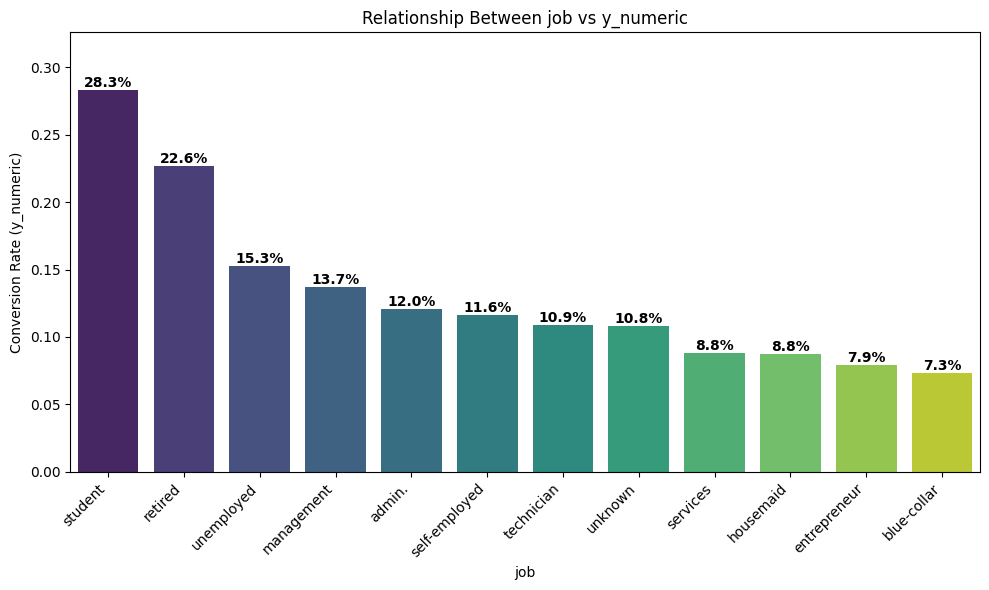

In [15]:
categorical_variable(clean_data,'job',target_col='y_numeric', palette='viridis')

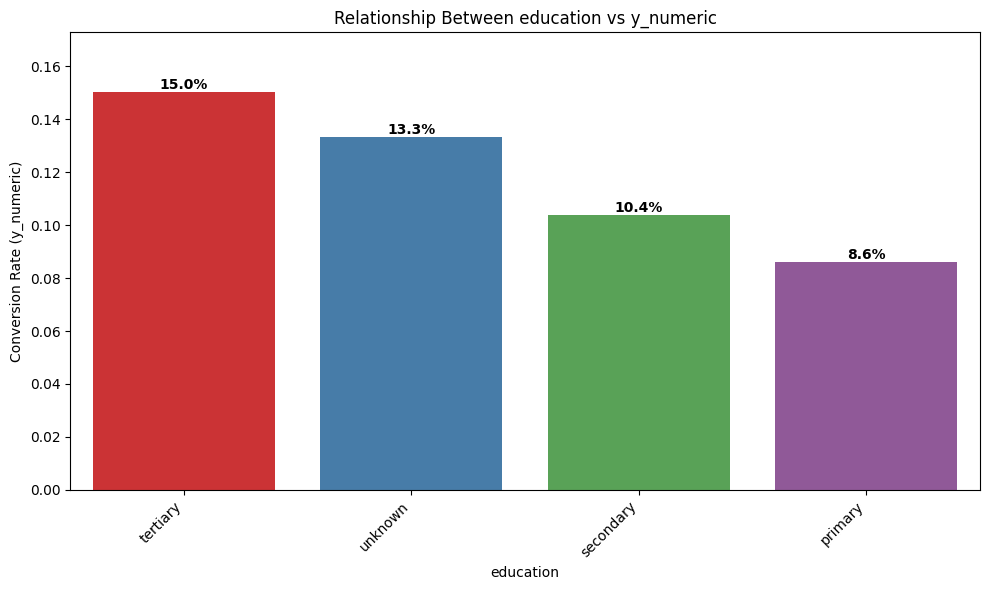

In [16]:
categorical_variable(clean_data,'education',target_col='y_numeric', palette='Set1')

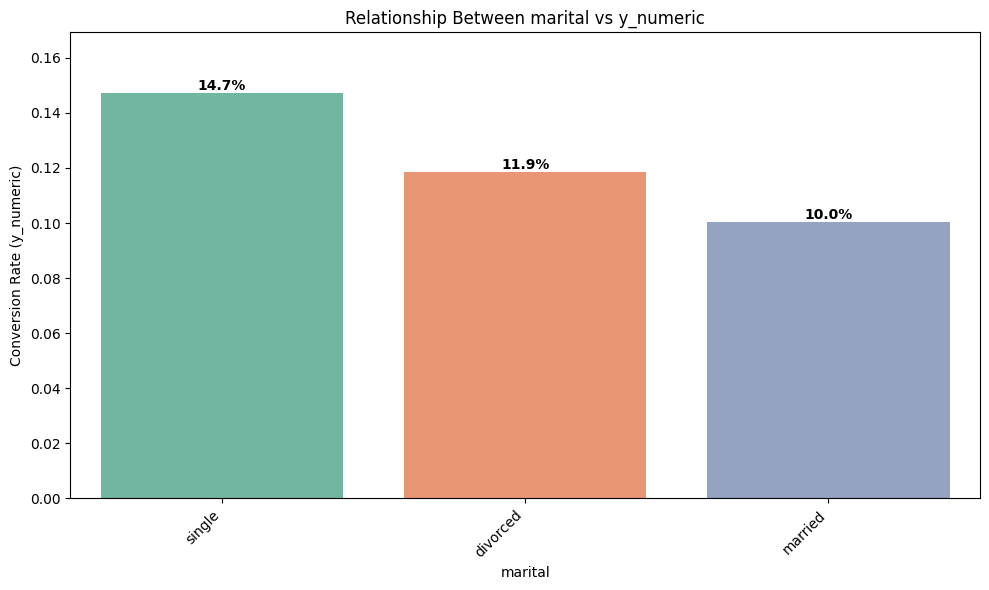

In [17]:
categorical_variable(clean_data,'marital',target_col='y_numeric', palette='Set2')

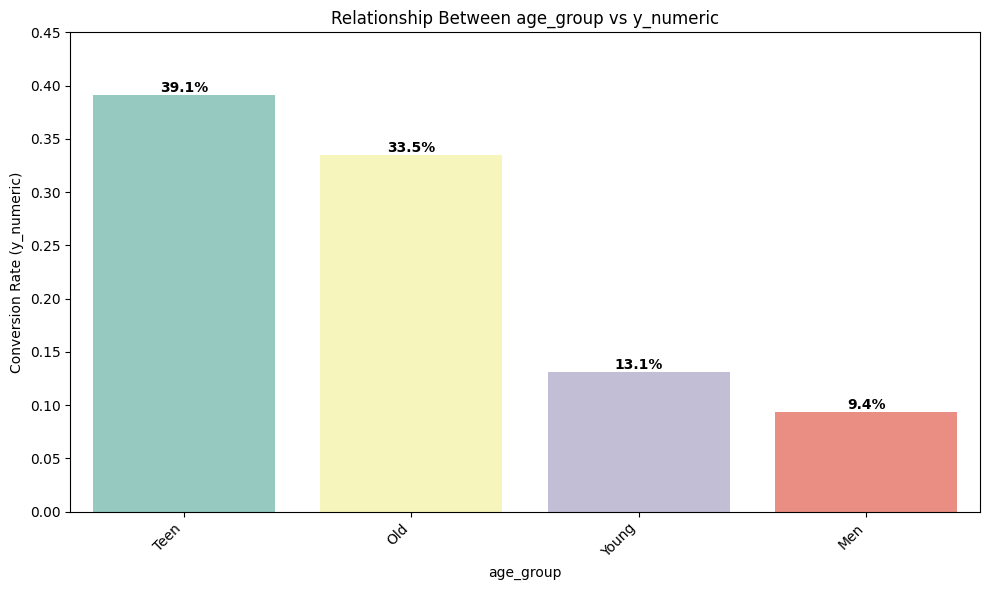

In [18]:
categorical_variable(clean_data,'age_group',target_col='y_numeric', palette='Set3')

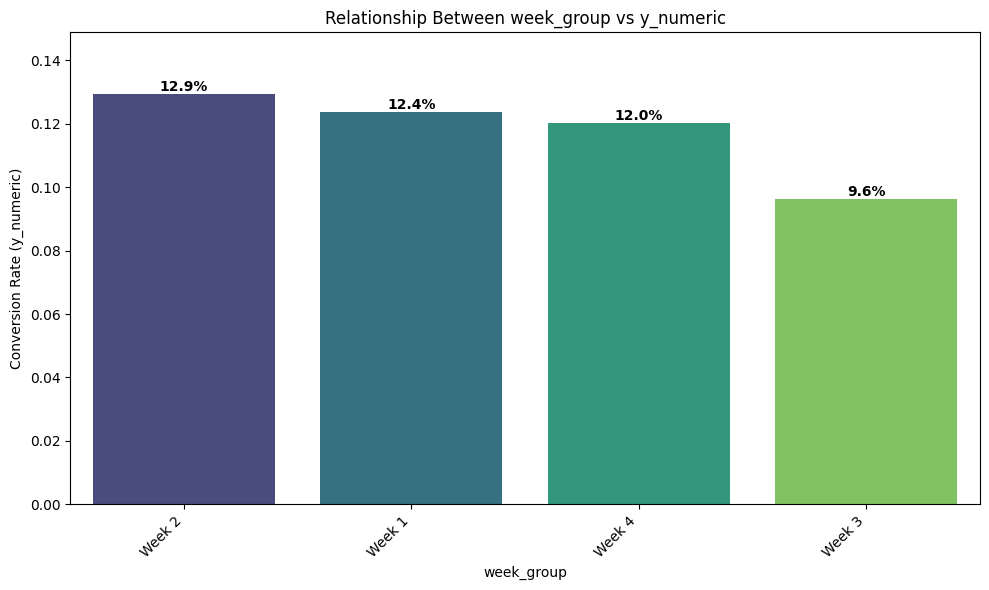

In [19]:
categorical_variable(clean_data,'week_group',target_col='y_numeric', palette='viridis')

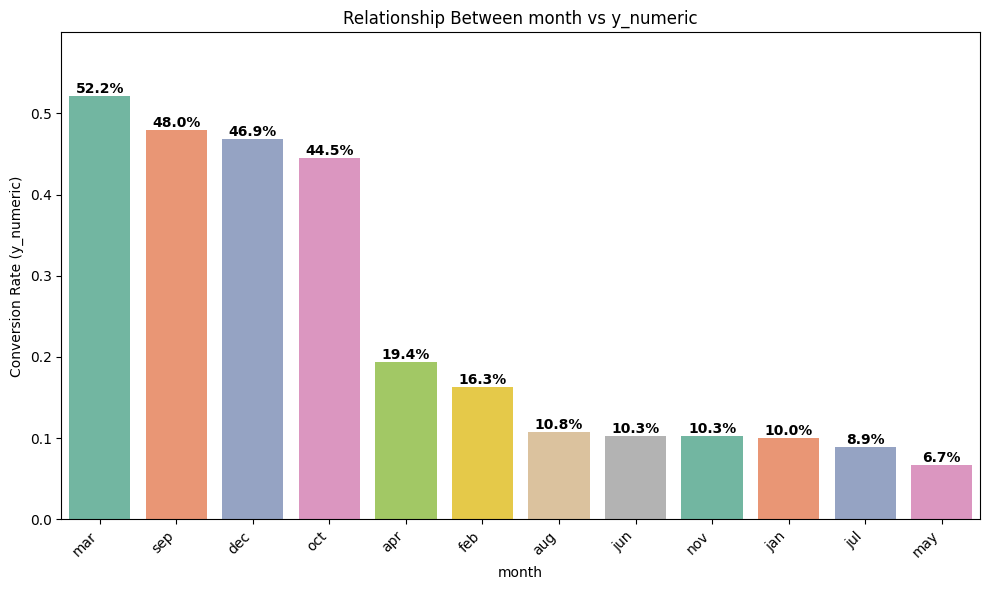

In [20]:
categorical_variable(clean_data,'month',target_col='y_numeric', palette='Set2')

In [21]:
def plot_numeric_kde(df, num_col, target_col):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df[df[target_col]==0][num_col], 
                label='Not Subscribed', fill=True, alpha=0.5)
    sns.kdeplot(data=df[df[target_col]==1][num_col], 
                label='Subscribed', fill=True, alpha=0.5)
    plt.title(f'Density of {num_col} by Subscription')
    plt.xlabel(num_col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    path=f"C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\Task 4\\Relation {col} vs y_numeric.png"
    plt.savefig(path, dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none') 

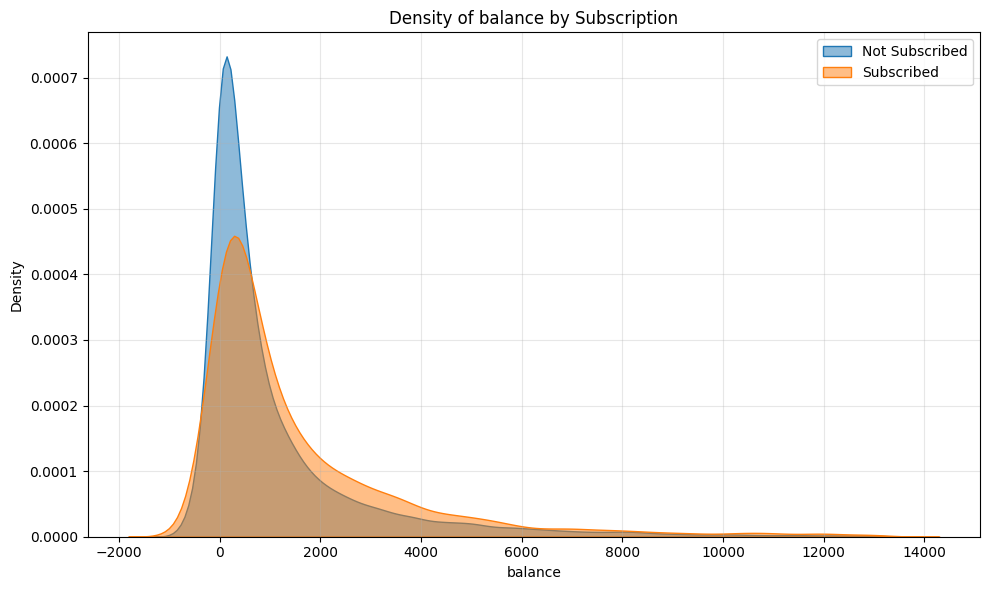

In [22]:
plot_numeric_kde(clean_data, 'balance', 'y_numeric')

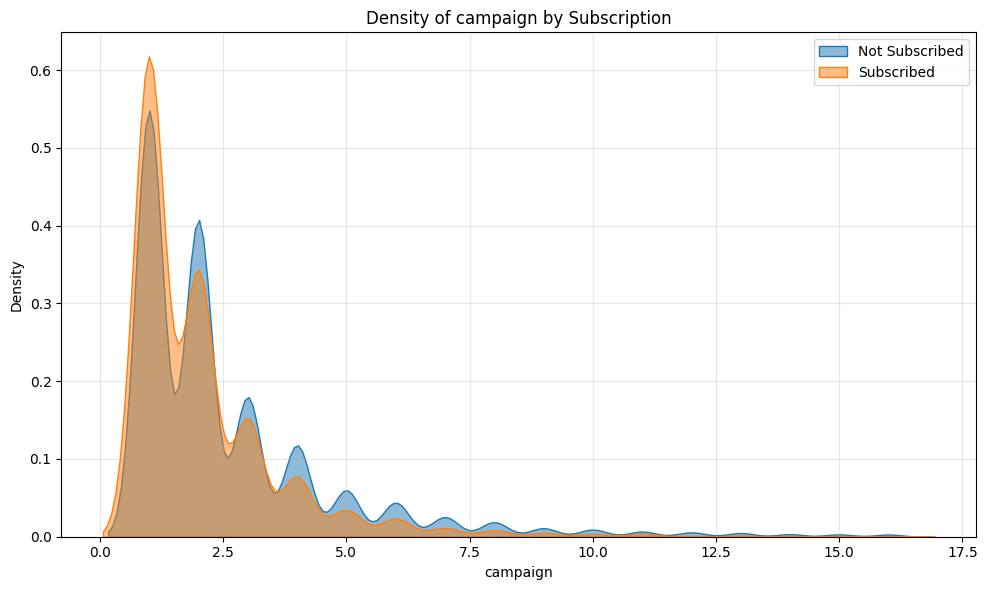

In [23]:
plot_numeric_kde(clean_data, 'campaign', 'y_numeric')

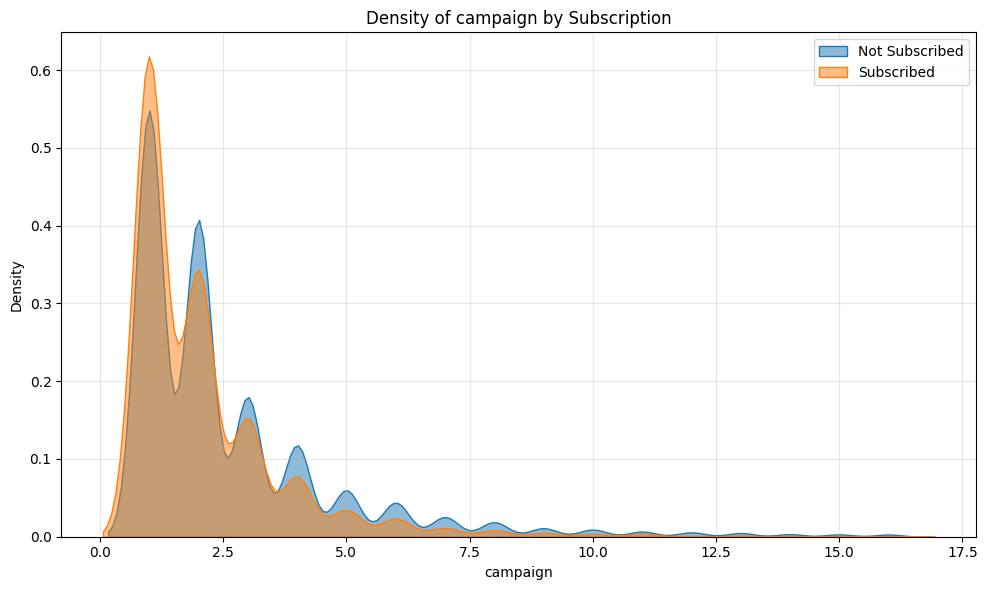

In [24]:
plot_numeric_kde(clean_data, 'campaign', 'y_numeric')

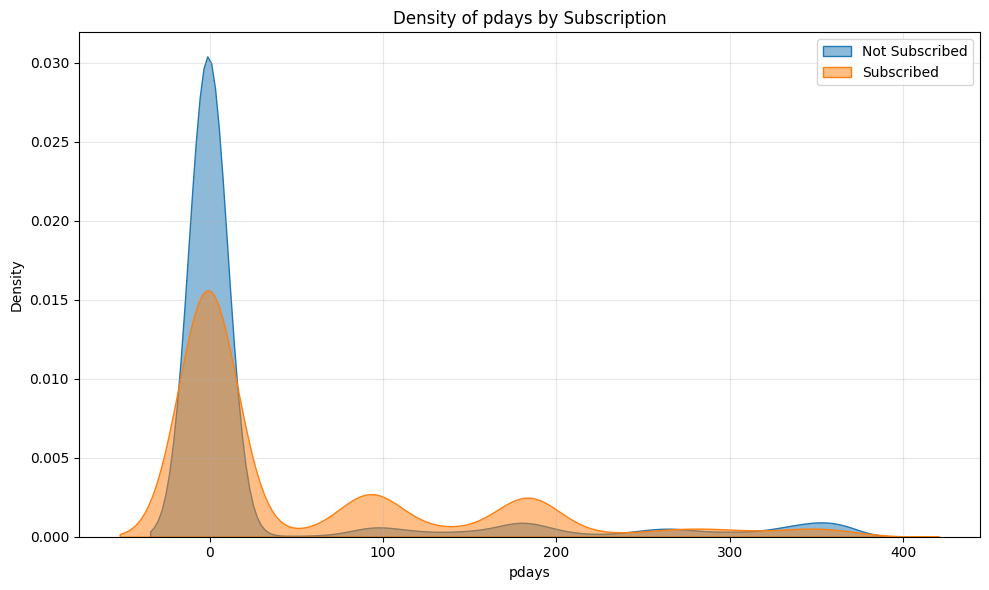

In [25]:
plot_numeric_kde(clean_data, 'pdays', 'y_numeric')

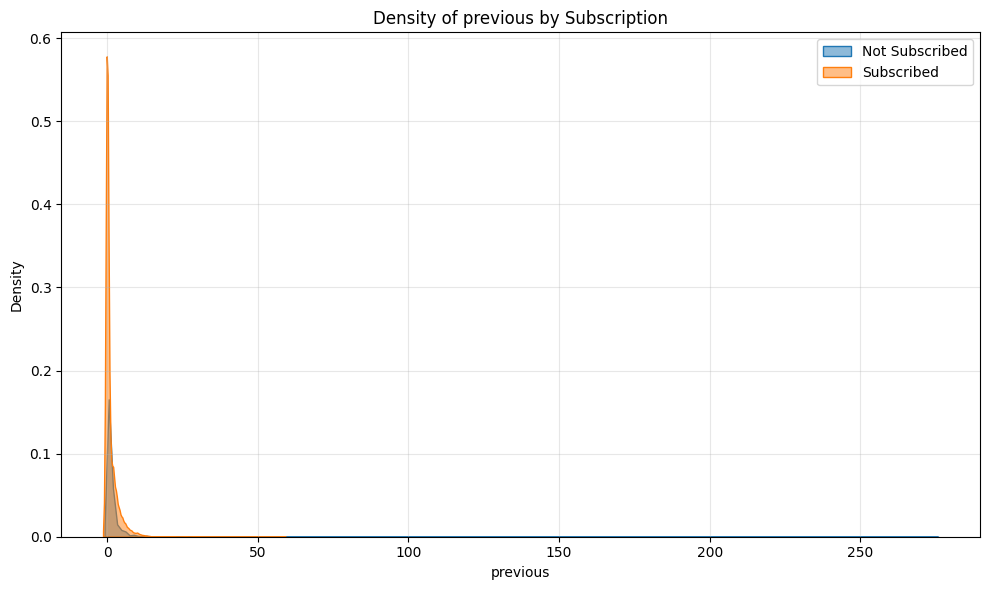

In [26]:
plot_numeric_kde(clean_data, 'previous', 'y_numeric')

In [27]:
df=pd.get_dummies(data=clean_data,columns=['job','marital','education','default','housing','contact','loan','month','poutcome','age_group','week_group']
                  ,dtype=int,drop_first=True)
df.head()

,balance,campaign,pdays,previous,y,y_numeric,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_sep,poutcome_other,poutcome_success,poutcome_unknown,age_group_Old,age_group_Teen,age_group_Young,week_group_Week 2,week_group_Week 3,week_group_Week 4
0,2143,1,-1,0,no,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,29,1,-1,0,no,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,1,-1,0,no,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1506,1,-1,0,no,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,-1,0,no,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


# Feature Selection

In [28]:
def select_features(df, target='y_numeric', threshold=0.01):
    corr = df.corr()[target].abs()
    selected = corr[corr >= threshold].index.tolist()
    df_clean = df[selected].copy()
    
    print(f"Original: {len(df.columns)} features")
    print(f"Selected: {len(df_clean.columns)} features")
    print(f"Removed: {len(df.columns)-len(df_clean.columns)} features")
    
    return df_clean

In [29]:
num=df.select_dtypes(include='number')
df_clean = select_features(num,threshold=0.05)
df_clean.shape

Original: 46 features
Selected: 22 features
Removed: 24 features


(43475, 22)

In [30]:
df_clean_no = df_clean[df_clean['y_numeric']==0]
df_clean_yes = df_clean[df_clean['y_numeric']==1].sample(38440,replace=True)
data=pd.concat([df_clean_no,df_clean_yes],axis=0)

In [31]:
x=data.drop(['y_numeric'],axis='columns')
y=data['y_numeric']

# Splitting Dataset

In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,stratify=y,test_size=0.25)

# Training and Evaluating Model

In [33]:
RF=RandomForestClassifier(class_weight='balanced')
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)
score = f1_score(y_test, y_pred)
print(f"F1 Score of this Model is {score:.4f}")

F1 Score of this Model is 0.9416


In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      9610
           1       0.90      0.99      0.94      9610

    accuracy                           0.94     19220
   macro avg       0.94      0.94      0.94     19220
weighted avg       0.94      0.94      0.94     19220



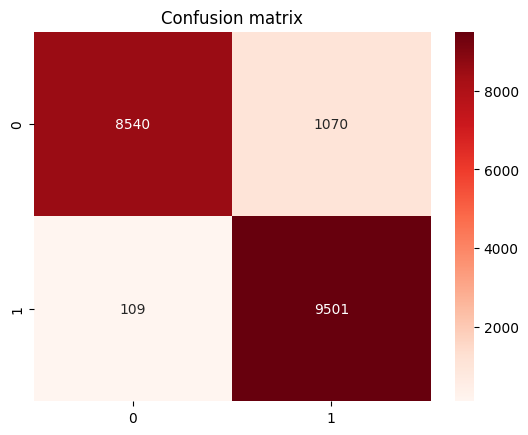

In [35]:
con=confusion_matrix(y_test,y_pred)
sns.heatmap(con,annot=True,cmap='Reds',fmt='d')
plt.title('Confusion matrix')
path=f"C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\Task 4\\confusion_matrix.png"
plt.savefig(path, dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none') 

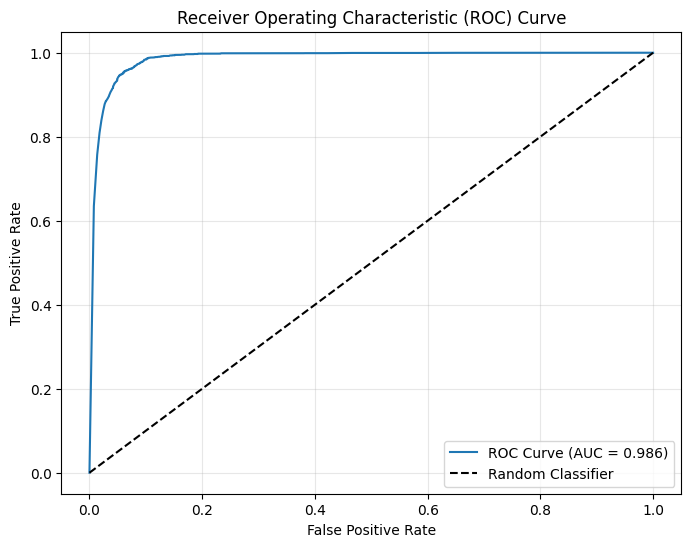

In [36]:
y_pred_proba = RF.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True, alpha=0.3)
path=f"C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Phase 2\\Task 4\\ROC Curve.png"
plt.savefig(path, dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none') 
plt.show()

# 5 Predictions Using SHAP

In [37]:
explainer = shap.TreeExplainer(RF)
sample_indices = [0, 1, 2, 3, 4]
shap_values = explainer.shap_values(x_test.iloc[sample_indices])
shap.initjs()
for i in range(5):
    print(f"\n=== Explanation for Sample {i} ===")
    display(shap.force_plot(
        explainer.expected_value[1],  
        shap_values[i, :, 1],         
        x_test.iloc[i],              
        matplotlib=False
    ))


=== Explanation for Sample 0 ===



=== Explanation for Sample 1 ===



=== Explanation for Sample 2 ===



=== Explanation for Sample 3 ===



=== Explanation for Sample 4 ===
